# Step 1: Dataset Preparation

- Define dataset directories  
- Limit to 300 images per class  
- Split into 80% train / 20% validation  
- Copy images into structured folders


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [3]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

# Directories
DATASET_DIR = "/content/drive/MyDrive/DATASET/GARBAGE_DATASET/images"
WORK_DIR = "/content/small_dataset"
TRAIN_DIR = os.path.join(WORK_DIR, "train")
VAL_DIR = os.path.join(WORK_DIR, "val")

# Reset folders
if os.path.exists(WORK_DIR):
    shutil.rmtree(WORK_DIR)
os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(VAL_DIR, exist_ok=True)

CLASSES = ["trash", "plastic", "paper", "metal", "glass", "cardboard"]
LIMIT = 300
VAL_SPLIT = 0.2

for cls in CLASSES:
    src = os.path.join(DATASET_DIR, cls)
    train_dst = os.path.join(TRAIN_DIR, cls)
    val_dst = os.path.join(VAL_DIR, cls)
    os.makedirs(train_dst, exist_ok=True)
    os.makedirs(val_dst, exist_ok=True)

    # take first 300 sorted images
    images = sorted(os.listdir(src))[:LIMIT]

    # split train/val
    split_idx = int(LIMIT * (1 - VAL_SPLIT))
    train_imgs = images[:split_idx]
    val_imgs = images[split_idx:]

    for img in train_imgs:
        shutil.copy(os.path.join(src, img), os.path.join(train_dst, img))
    for img in val_imgs:
        shutil.copy(os.path.join(src, img), os.path.join(val_dst, img))

    print(f"{cls}: {len(train_imgs)} train, {len(val_imgs)} val")


trash: 240 train, 60 val
plastic: 240 train, 60 val
paper: 240 train, 60 val
metal: 240 train, 60 val
glass: 240 train, 60 val
cardboard: 240 train, 60 val


# Step 2: Data Generators

- Normalize pixel values (0–1)  
- Apply augmentation: rotation, shift, shear, zoom, flip  
- Build training and validation generators


In [4]:
IMG_SIZE = (160, 160)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="categorical"
)
val_gen = val_datagen.flow_from_directory(
    VAL_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="categorical"
)


Found 1440 images belonging to 6 classes.
Found 360 images belonging to 6 classes.


# Step 3: Model Building (Transfer Learning)

- Base model: MobileNetV2 (pretrained on ImageNet)  
- Fine-tune last 50 layers  
- Custom head: GAP → Dense(256, ReLU) → Dropout(0.4) → Softmax(6 classes)


In [5]:
base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights="imagenet")
base_model.trainable = True   # unfreeze for fine-tuning

# Freeze bottom layers, fine-tune top
for layer in base_model.layers[:-50]:
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(len(CLASSES), activation="softmax")
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit(train_gen, validation_data=val_gen, epochs=10)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.3228 - loss: 1.8160 - val_accuracy: 0.5972 - val_loss: 1.1298
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.6866 - loss: 0.8787 - val_accuracy: 0.6361 - val_loss: 1.0046
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.7912 - loss: 0.6169 - val_accuracy: 0.6528 - val_loss: 0.9098
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8593 - loss: 0.4165 - val_accuracy: 0.6861 - val_loss: 0.8609
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.8814 - loss: 0.3703 - val_accuracy: 0.7222 - val_loss: 0.7922
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.8982 - loss: 0.3039 - val_accuracy: 0.7250 - val_loss: 0.7724
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.9233 - loss: 0.2356 - val_accuracy: 0.6972 - val_loss: 0.8347
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9533 - loss: 0.1710 - val_accuracy: 0.7306 - val_loss:

# Step 4: Training & Evaluation

- Track train/val accuracy and loss  
- Plot curves  
- Save plots into `/results`


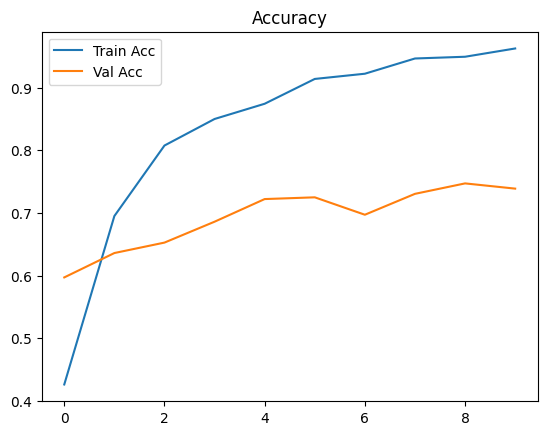

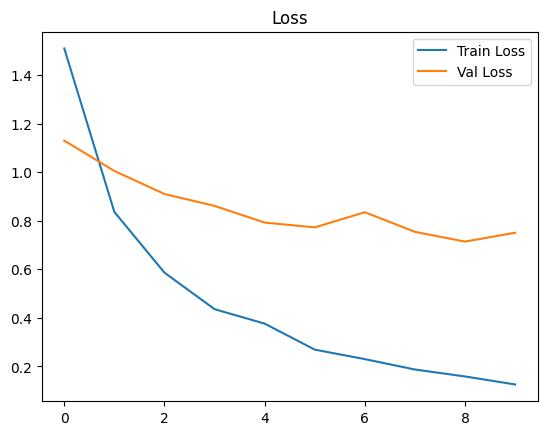

In [6]:
os.makedirs("results", exist_ok=True)

# Accuracy Plot
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.legend(); plt.title("Accuracy")
plt.savefig("results/accuracy_curve.png", dpi=300, bbox_inches="tight")
plt.show()

# Loss Plot
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.legend(); plt.title("Loss")
plt.savefig("results/loss_curve.png", dpi=300, bbox_inches="tight")
plt.show()


# Step 5: Confusion Matrix


12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 789ms/step


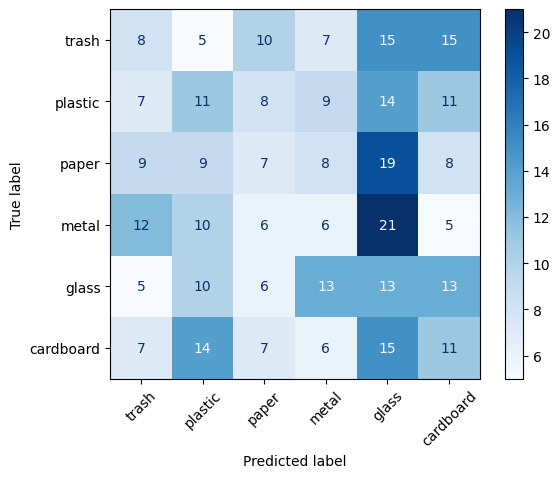

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

val_labels = val_gen.classes
val_pred = model.predict(val_gen, verbose=1)
val_pred_classes = np.argmax(val_pred, axis=1)

cm = confusion_matrix(val_labels, val_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.savefig("results/confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()


# Step 6: Performance Report

- Overall Validation Accuracy  
- Precision, Recall, F1 per class  
- Final Confusion Matrix


In [9]:
from sklearn.metrics import classification_report

# Evaluate
val_loss, val_acc = model.evaluate(val_gen, verbose=0)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

# Classification Report
print("\nClassification Report:")
print(classification_report(val_labels, val_pred_classes, target_names=CLASSES))


Validation Accuracy: 73.89%

Classification Report:
              precision    recall  f1-score   support

       trash       0.17      0.13      0.15        60
     plastic       0.19      0.18      0.18        60
       paper       0.16      0.12      0.13        60
       metal       0.12      0.10      0.11        60
       glass       0.13      0.22      0.17        60
   cardboard       0.17      0.18      0.18        60

    accuracy                           0.16       360
   macro avg       0.16      0.16      0.15       360
weighted avg       0.16      0.16      0.15       360

